In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.segmentation import deeplabv3_resnet50
from collections import Counter


In [2]:
#检查是否cuda可用
import torch
print(torch.cuda.device_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#name
print(torch.cuda.get_device_name(0))
#cuda verison
print(torch.version.cuda)
print(torch.cuda.is_available())


1
NVIDIA GeForce RTX 2070
12.1
True


In [3]:
path = '61541v001/data/WildScenes'

image_path  = []
indexLabel_path = []
label_path = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.png'):
            newPath = os.path.join(root, file)
            if root.endswith('image'):
                image_path.append(newPath)
            elif root.endswith('indexLabel'):
                indexLabel_path.append(newPath)
            elif root.endswith('label'):
                label_path.append(newPath)

In [4]:
image_path.sort()
indexLabel_path.sort()
label_path.sort()
#选取前10张图片
image_path = image_path[:100]
indexLabel_path = indexLabel_path[:100]
label_path = label_path[:100]

In [5]:
import torch
print(torch.cuda.is_available())


True


In [6]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])


In [7]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(Dataset):
    def __init__(self, image_path, indexLabel_path,label_path, transform=None):
        self.imgs= image_path
        self.masks = indexLabel_path
        self.labels = label_path
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        label = self.labels[idx]
        #image convert to rgb
        image = Image.open(img_path).convert("RGB")
        #mask convert to grayscale
        mask = Image.open(mask_path)
       
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Ensure mask is 3D tensor [height, width] after transform
        mask = mask.squeeze(0)
        return image, mask

In [8]:

dataset = CustomImageDataset(image_path, indexLabel_path, label_path, transform = transform)

In [9]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



In [10]:
# Count the unique labels in the masks and their pixel counts
unique_labels = set()
pixel_counts = Counter()

for _, mask, in dataset:
    unique_labels.update(np.unique(mask))
    pixel_counts.update(mask.flatten())

# Print the count of unique labels
print(f"Number of unique labels in masks: {len(unique_labels)}")
print(f"Unique labels in masks: {unique_labels}")


Number of unique labels in masks: 18
Unique labels in masks: {0.007843138, 0.011764706, 0.023529412, 0.015686275, 0.019607844, 0.02745098, 0.03137255, 0.03529412, 0.039215688, 0.043137256, 0.047058824, 0.050980393, 0.05490196, 0.05882353, 0.0627451, 0.06666667, 0.003921569, 0.07058824}


In [11]:
# Create DeepLabV3 model with ResNet50 backbone
model = deeplabv3_resnet50(pretrained=False, num_classes=21)  # Adjust num_classes as needed

print(model)

C:\Users\89304\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\89304\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Epoch [1/10], Loss: 2.2654, IoU: 0.1240
Epoch [2/10], Loss: 0.7255, IoU: 0.2497
Epoch [3/10], Loss: 0.2513, IoU: 1.0000
Epoch [4/10], Loss: 0.1038, IoU: 1.0000
Epoch [5/10], Loss: 0.0533, IoU: 1.0000
Epoch [6/10], Loss: 0.0328, IoU: 1.0000
Epoch [7/10], Loss: 0.0234, IoU: 1.0000
Epoch [8/10], Loss: 0.0184, IoU: 1.0000
Epoch [9/10], Loss: 0.0154, IoU: 1.0000
Epoch [10/10], Loss: 0.0134, IoU: 1.0000
Mean IoU: [0.96537751 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
Training complete.


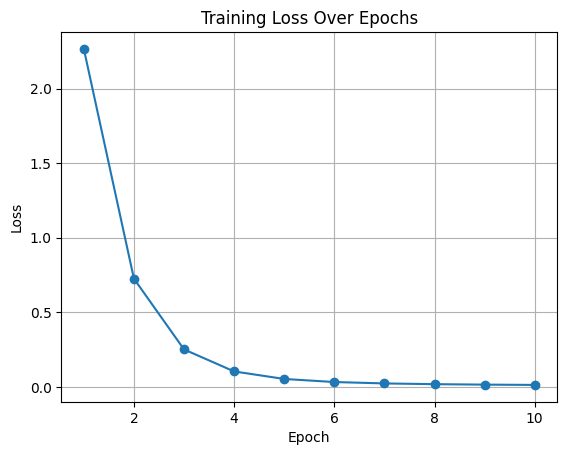

C:\Users\89304\AppData\Local\Temp\ipykernel_17276\1837066527.py:68: RuntimeWarning: Mean of empty slice
  mean_epoch_iou = [np.nanmean(ious[i*len(dataloader):(i+1)*len(dataloader)], axis=0) for i in range(num_epochs)]


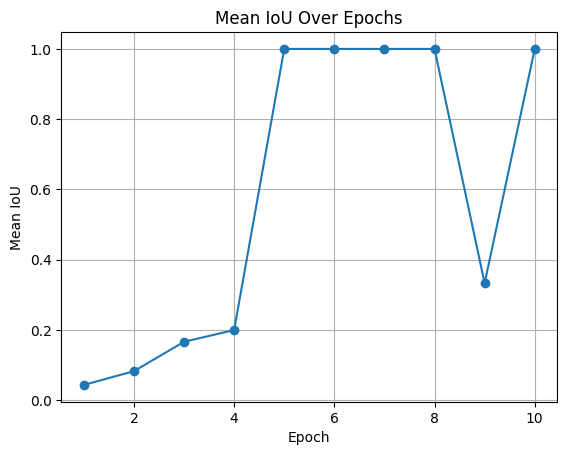

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust the number of epochs as needed
device = torch.device('cuda')
model.to(device)
def compute_iou(pred_mask, true_mask, num_classes):
    ious = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        
        intersection = (pred_inds[true_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + true_inds.long().sum().item() - intersection
        
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in IoU calculation
        else:
            ious.append(float(intersection) / max(union, 1))
    
    return np.array(ious)
losses = []
ious = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(images)['out']  # Extract the tensor with key 'out'
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*images.size(0)
        
        # Compute IoU for each batch
        pred_masks = outputs.argmax(1)
        batch_iou = compute_iou(pred_masks.cpu(), masks.cpu(), num_classes=15)
        ious.append(batch_iou)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, IoU: {np.nanmean(batch_iou):.4f}')

mean_iou = np.nanmean(np.array(ious), axis=0)
print(f'Mean IoU: {mean_iou}')
print('Training complete.')

# Plot the loss over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Plot the IoU over epochs
mean_epoch_iou = [np.nanmean(ious[i*len(dataloader):(i+1)*len(dataloader)], axis=0) for i in range(num_epochs)]
plt.figure()
plt.plot(range(1, num_epochs + 1), [np.nanmean(iou) for iou in mean_epoch_iou], marker='o')
plt.title('Mean IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.grid()
plt.show()